# Quant Analyst Intern Assessment

## Section #2: Multivariate Time Series Analysis

### In this section, you will build a Multivariate Time Series Model. Please use Jupyter Notebook for this exercise. You may answer all questions in MARKDOWN inside the Jupyter Notebook.


### a. Propose up to five factors that may affect the USD/CAD trading range and explain your reasons for making these assumptions. Also explain the type of data frequency you will use (for example, intraday 5 minutes/daily/weekly).

*I choose the following four factors:
WTI crude oil price, xauusd, U.S. retail sales year-on-year, U.S. crude oil exports to Canada.*

*I think there are not many factors that affect USD/CAD. It is mainly considered from the oil price data and U.S. economic data.*

*First of all, the Canadian dollar is a commodity currency. Canada’s economic orientation is also dominated by exports. It is one of the important oil exporting countries. Therefore, rising oil prices may put a lot of pressure on the Canadian dollar. At this time, its purchasing power is limited. It will be greatly reduced, and it will depreciate against major currencies. It should be noted that although Canada exports a lot of oil, it also imports a lot of oil from the United States. A considerable part of this is that Canada first exported crude oil to the United States, then import it back from the United States. So I chose the WTI crude oil price and the amount of crude oil exported from the U.S. to Canada.*

*Secondly, US consumption data, QE, Taper, and fiscal policies will all have an impact on usd/cad. Gold is closely related to the US dollar, so I chose xauusd. Since consumption accounts for a large proportion of the US economy, so from the perspective of consumption data I chose the retail sales year-on-year, and similarly, I can also choose the consumer confidence index instead. Here is a detail, the poor employment data of the United States will drive the Canadian dollar to rise, because the United States is full of employment, and the production of shale oil also increases, the oil prices fall.*

*The specific choice actually depends on the strategy in different periods. For example, the current international oil prices are rising, but Canadian export oil is selling well, causing usdcad to fall a lot. If the U.S. dollar taper, international oil prices are weak, OPEC increases production capacity, and the U.S. dollar appreciates, the Canadian dollar will weaken relatively, and the logic will become dependent on US consumption data and manufacturing data.*

*In the actual trading strategy, the higher the data frequency, the better. The FX leverage ratio is very high, so it is trading back and forth in the min range, and no one can bear the fluctuation of the next day.*

*And I think the best construction of this model should be based on the long-term trend of the U.S. dollar index and the long-term trend of international oil prices, to build a large-scale model of usdcad, and build it with mathematical data from a macro perspective. There is a dual relationship between the surface and the inside called the trend structure in technical theory, that is, any trend in a large level must fall in a certain direction. The long-term trend is the general direction, and the time series modeling can be better in the changing market to capture the high and low points of our trading, so it will be more useful in higher frequency transactions.*

*However, due to the limited frequency and range of data I can obtain, and in order to simplify the model, the data selected below are all daily frequencies.*

### b.	Causality & Statistical Signifiance 

   i. Utilize the Granger’s Causality Test to test foe causation in the variables that you have selected. Construct a matrix to show the p-values of the variables against one another (i.e., you also need to show that there are possible relationships between one another; not just USD/CAD).   

   ii. [Test for Statistical Significance Between Time Series] Use the Johassen’s test of cointegration to check statistical significance in your variables. 

### c.	[Check for Stationarity] Implement an ADF test to check for stationarity. If it is not stationary, conduct a first-order differencing and re-check for stationarity. Show the ADF p-values for all the selected variables. If first-order differencing is not stationary, conduct a second-order differencing and re-run the ADF test.

### d.	[Model Selection] Using fit comparison estimates of AIC, BIC, FPE, and HQIC. Using the Fit comparison estimates to derive the most optimal number of lags for the model.


### Data Preprocessing


In [331]:
# Data Preprocessing

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

def Interpolation(data_process):
    
    """
    Interpolation

    Perform arithmetic interpolation on the missing values of a column of data
    """
    
    j = 0
    df_seq = []
    df = data_process.values
    
    # arithmetic interpolation, the value of 0 is also considered here.
    for i in range(len(df)):
        if df[i] != 0:
            diff = (df[i]-df[j])/(i-j)
            data_arange = np.arange(df[j], df[i], diff)
            j = i
            for num in range(len(data_arange)):
                df_seq.append(data_arange[num])
                
        #if i == len(df)-1 and df[i] != 0:
        #    df_seq.append(df[i])
        
        if i == len(df)-1 and df[i] == 0:
            end = df[j] + diff * (i-j)
            data_arange = np.arange(df[j], end, diff)
            for num in range(len(data_arange)):
                df_seq.append(data_arange[num])
            if len(df_seq) != len(df):
                df_seq.append(end)
                      
    return df_seq


data = pd.read_csv('./HistoryData.csv')  # Read data.

data['Date'] = pd.to_datetime(data['Date'])
data.index = data['Date']  # Convert date format

# data.info()

data['WTI'] = data['WTI'].bfill() # There are few missing values in wti, so only mean interpolation is used.

data = data.fillna(0)

# These two are monthly data, and its trend needs to be retained, so use arithmetic interpolation
data['Sales_Rate'] = Interpolation(data['Sales_Rate'])
data['CrudeOilExports_UStoCanada'] = Interpolation(data['CrudeOilExports_UStoCanada'])
data = data.drop(data[(data['Sales_Rate']==0) |(data['CrudeOilExports_UStoCanada']==0)].index)

data.to_csv('./train_data.csv', index = False, header = True)
data.describe()

,WTI,XAU_USD,Sales_Rate,CrudeOilExports_UStoCanada,USD_CAD
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,65.391900,1798.159350,0.204466,798.112727,1.251170
std,6.900871,53.297838,0.126674,145.439478,0.021168
min,47.620000,1681.240000,0.004700,41.700000,1.203200
25%,61.097500,1760.907500,0.149682,816.750000,1.242725
50%,65.855000,1793.475000,0.153936,830.090909,1.256150
75%,70.640000,1830.240000,0.264550,847.208075,1.265625
max,79.350000,1949.350000,0.534200,921.000000,1.284900


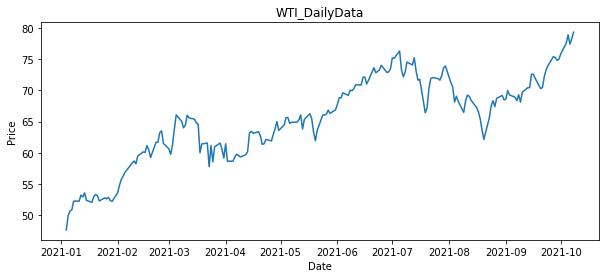

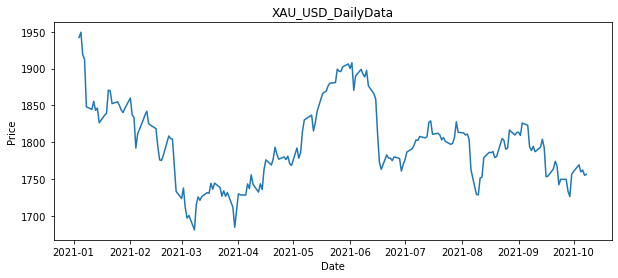

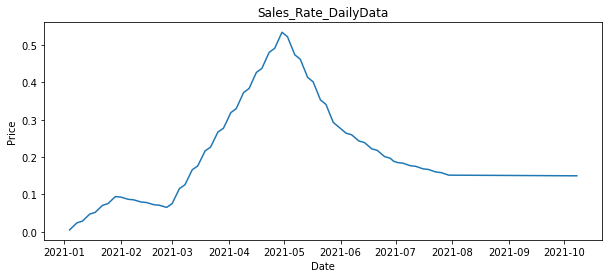

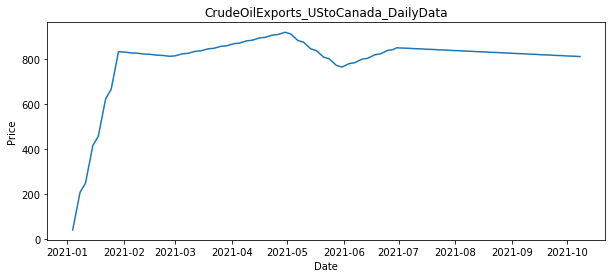

In [337]:
# Data Visualization
DailyWTI = plt.figure(figsize = (10, 4))
ax = DailyWTI.add_subplot(111)
ax.set(title = 'WTI_DailyData',
        ylabel = 'Price', xlabel='Date')

plt.plot(data['Date'], data['WTI'])
plt.show()    

DailyXAU_USD = plt.figure(figsize = (10, 4))
ax = DailyXAU_USD.add_subplot(111)
ax.set(title = 'XAU_USD_DailyData',
        ylabel = 'Price', xlabel='Date')

plt.plot(data['Date'], data['XAU_USD'])
plt.show() 

DailySales_Rate = plt.figure(figsize = (10, 4))
ax = DailySales_Rate.add_subplot(111)
ax.set(title = 'Sales_Rate_DailyData',
        ylabel = 'Price', xlabel='Date')

plt.plot(data['Date'], data['Sales_Rate'])
plt.show()    

DailyCrudeOilExports_UStoCanada = plt.figure(figsize = (10, 4))
ax = DailyCrudeOilExports_UStoCanada.add_subplot(111)
ax.set(title = 'CrudeOilExports_UStoCanada_DailyData',
        ylabel = 'Price', xlabel='Date')

plt.plot(data['Date'], data['CrudeOilExports_UStoCanada'])
plt.show() 

### Granger Causality Tests

##### if p is less than 0.05, Granger causality is considered

In [333]:
def Grangercausalitytests(data, maxlag_num):
    
    """
    Granger Causality Tests

    if p is less than 0.05, Granger causality is considered
    """
    
    from statsmodels.tsa.stattools import grangercausalitytests
    grangercausalitytests(data, maxlag=maxlag_num)

    
# All variables need to be tested
print('Grangercausalitytests Result between WTI and USD_CAD')
Grangercausalitytests(data[['WTI', 'USD_CAD']], 3)
      
print('\nGrangercausalitytests Result between XAU_USD and USD_CAD')
Grangercausalitytests(data[['XAU_USD', 'USD_CAD']], 3)

print('\nGrangercausalitytests Result between Sales_Rate and USD_CAD')
Grangercausalitytests(data[['Sales_Rate', 'USD_CAD']], 3)
      
print('\nGrangercausalitytests Result between CrudeOilExports_UStoCanada and USD_CAD')
Grangercausalitytests(data[['CrudeOilExports_UStoCanada', 'USD_CAD']], 3)


print('\nGrangercausalitytests Result between WTI and CrudeOilExports_UStoCanada')
Grangercausalitytests(data[['WTI', 'CrudeOilExports_UStoCanada']], 3)
      
print('\nGrangercausalitytests Result between Sales_Rate and CrudeOilExports_UStoCanada')
Grangercausalitytests(data[['Sales_Rate', 'CrudeOilExports_UStoCanada']], 3)
      
print('\nGrangercausalitytests Result between XAU_USD and CrudeOilExports_UStoCanada')
Grangercausalitytests(data[['XAU_USD', 'CrudeOilExports_UStoCanada']], 3)


print('\nGrangercausalitytests Result between WTI and Sales_Rate')
Grangercausalitytests(data[['WTI', 'Sales_Rate']], 3)
      
print('\nGrangercausalitytests Result between XAU_USD and Sales_Rate')
Grangercausalitytests(data[['XAU_USD', 'Sales_Rate']], 3)


print('\nGrangercausalitytests Result between WTI and XAU_USD')
Grangercausalitytests(data[['WTI', 'XAU_USD']], 3)

Grangercausalitytests Result between WTI and USD_CAD

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1709  , p=0.6797  , df_denom=196, df_num=1
ssr based chi2 test:   chi2=0.1735  , p=0.6770  , df=1
likelihood ratio test: chi2=0.1735  , p=0.6771  , df=1
parameter F test:         F=0.1709  , p=0.6797  , df_denom=196, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8390  , p=0.0232  , df_denom=193, df_num=2
ssr based chi2 test:   chi2=7.8770  , p=0.0195  , df=2
likelihood ratio test: chi2=7.7243  , p=0.0210  , df=2
parameter F test:         F=3.8390  , p=0.0232  , df_denom=193, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4894  , p=0.0617  , df_denom=190, df_num=3
ssr based chi2 test:   chi2=7.7433  , p=0.0516  , df=3
likelihood ratio test: chi2=7.5950  , p=0.0552  , df=3
parameter F test:         F=2.4894  , p=0.0617  , df_denom=190, df_num=3

Grangercausalitytests Result between XAU

parameter F test:         F=0.8713  , p=0.4201  , df_denom=193, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9406  , p=0.4221  , df_denom=190, df_num=3
ssr based chi2 test:   chi2=2.9258  , p=0.4032  , df=3
likelihood ratio test: chi2=2.9043  , p=0.4066  , df=3
parameter F test:         F=0.9406  , p=0.4221  , df_denom=190, df_num=3


### ADF: Augmented Dickey-Fuller Unit Root  Tests

##### Check if it is a stationary series

Resulty of ADF -- WTI
Result of ADF--ct Test 
timeseries_adf :  (-3.101688860491678, 0.10582886840065409, 0, 199, {'1%': -4.004997848936356, '5%': -3.4327862452981046, '10%': -3.140144918368515}, 630.824366134776)
timeseries_diff1_adf :  (-14.697557519003498, 3.2262810895452605e-22, 0, 199, {'1%': -4.004997848936356, '5%': -3.4327862452981046, '10%': -3.140144918368515}, 638.6195746824538)
timeseries_diff2_adf :  (-7.375161319180977, 1.972524685743701e-09, 13, 186, {'1%': -4.008285142312431, '5%': -3.434362538624019, '10%': -3.1410680056243683}, 657.0809944444754)


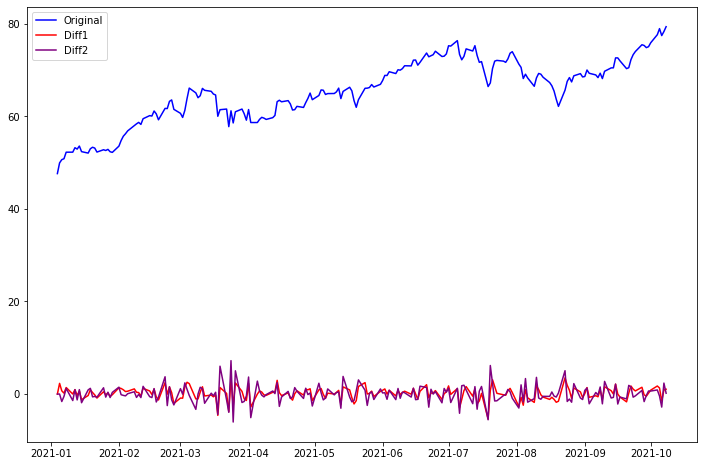

Result of ADF--c Test 
timeseries_adf :  (-1.849505004071287, 0.35617528707777313, 0, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 634.2884338240696)
timeseries_diff1_adf :  (-14.725100441737746, 2.713834187910377e-27, 0, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 636.627700405786)
timeseries_diff2_adf :  (-7.357429148951258, 9.697378991874675e-11, 13, 186, {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}, 655.3728671338179)


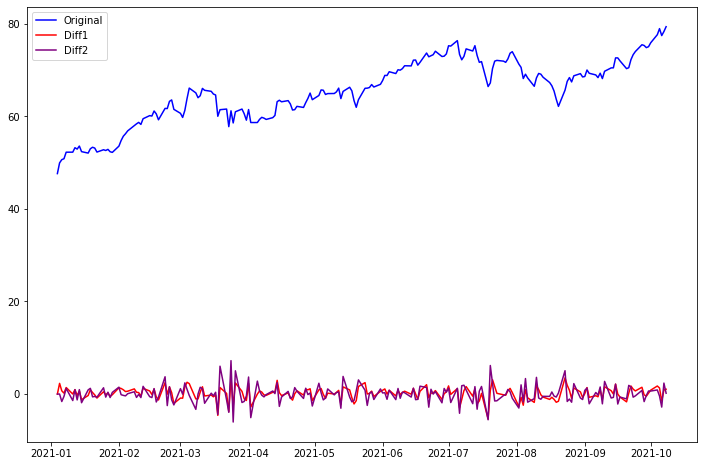

Result of ADF--nc Test 
timeseries_adf :  (1.494240783167146, 0.9665029447333595, 0, 199, {'1%': -2.5770667644756444, '5%': -1.942430759336949, '10%': -1.615550641718986}, 635.5024100275043)
timeseries_diff1_adf :  (-14.542048188355025, 4.613079286455446e-26, 0, 199, {'1%': -2.5770667644756444, '5%': -1.942430759336949, '10%': -1.615550641718986}, 636.9056187984525)
timeseries_diff2_adf :  (-7.3785010188215026, 8.509294350425607e-12, 13, 186, {'1%': -2.577865268817204, '5%': -1.9425364994337093, '10%': -1.6154665497285408}, 653.4570005941969)


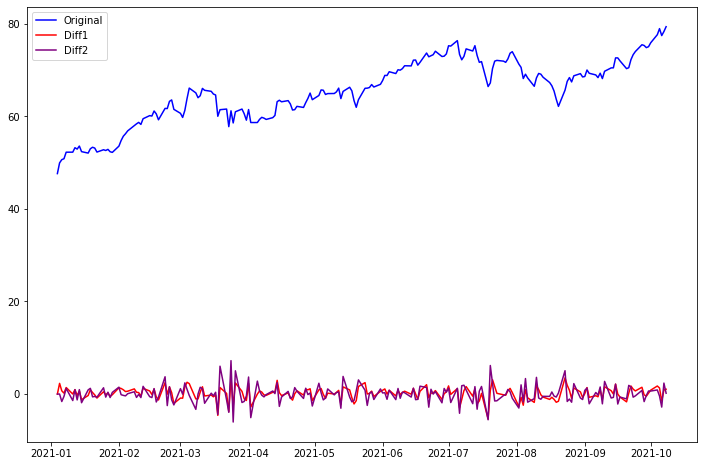

Resulty of ADF -- XAU_USD
Result of ADF--ct Test 
timeseries_adf :  (-3.14448582146424, 0.0960416976583221, 1, 198, {'1%': -4.005235140049614, '5%': -3.4329000694219, '10%': -3.1402115863254525}, 1513.004609560686)
timeseries_diff1_adf :  (-10.04262507932914, 1.8746582277861986e-15, 1, 198, {'1%': -4.005235140049614, '5%': -3.4329000694219, '10%': -3.1402115863254525}, 1516.7367906450572)
timeseries_diff2_adf :  (-9.142442419121563, 1.7333679280406592e-13, 7, 192, {'1%': -4.006711675454599, '5%': -3.433608194523564, '10%': -3.1406263010660807}, 1540.0032728450085)


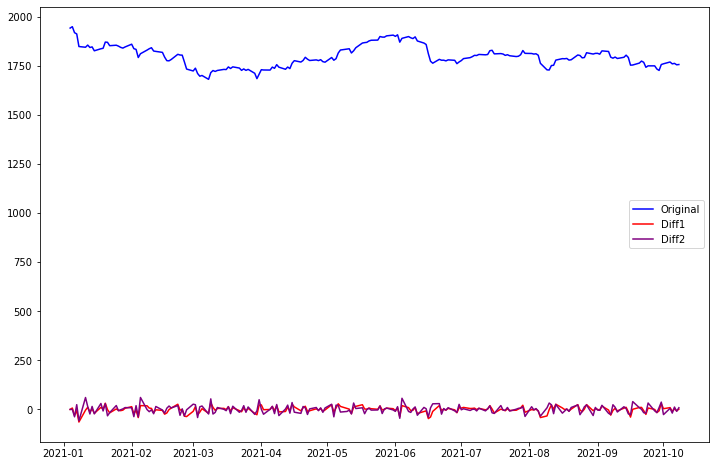

Result of ADF--c Test 
timeseries_adf :  (-3.2339984651546185, 0.018099153310006402, 1, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, 1511.100928504268)
timeseries_diff1_adf :  (-10.012440655853414, 1.7641077086889745e-17, 1, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, 1514.802590253932)
timeseries_diff2_adf :  (-9.15506001210167, 2.6233601808311222e-15, 7, 192, {'1%': -3.4648754262570978, '5%': -2.876714157488788, '10%': -2.574858699001736}, 1538.0264553119464)


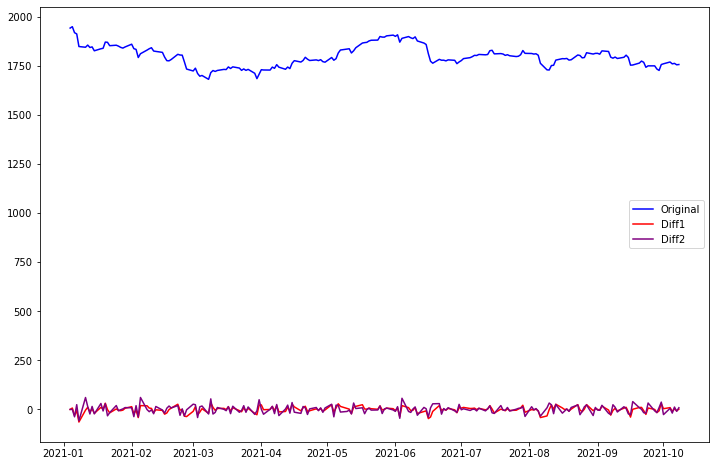

Result of ADF--nc Test 
timeseries_adf :  (-0.7826412695222938, 0.3778098616429016, 2, 197, {'1%': -2.57718269628179, '5%': -1.942446074560391, '10%': -1.6155383913198218}, 1514.7396244176898)
timeseries_diff1_adf :  (-9.98399170281167, 1.0824897404788863e-17, 1, 198, {'1%': -2.577124435261708, '5%': -1.9424383763922255, '10%': -1.6155445459389322}, 1513.044082226109)
timeseries_diff2_adf :  (-9.173652889972907, 6.968413508242904e-16, 7, 192, {'1%': -2.5774831803385414, '5%': -1.9424858284561723, '10%': -1.6155067050736038}, 1536.0267782788555)


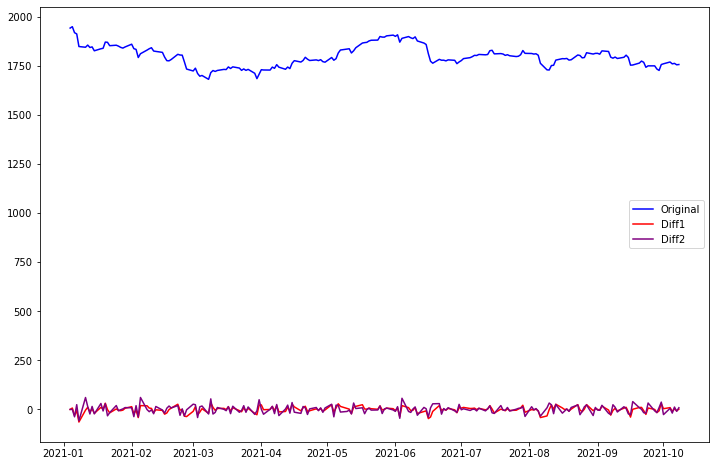

Resulty of ADF -- Sales_Rate
Result of ADF--ct Test 
timeseries_adf :  (-2.4819710861778157, 0.3370339354790416, 1, 198, {'1%': -4.005235140049614, '5%': -3.4329000694219, '10%': -3.1402115863254525}, -1760.4809473056034)
timeseries_diff1_adf :  (-2.28784912804277, 0.4406821579350714, 0, 199, {'1%': -4.004997848936356, '5%': -3.4327862452981046, '10%': -3.140144918368515}, -1756.1743370629902)
timeseries_diff2_adf :  (-14.004882868703799, 1.0862899729485266e-21, 0, 199, {'1%': -4.004997848936356, '5%': -3.4327862452981046, '10%': -3.140144918368515}, -1751.6902012227251)


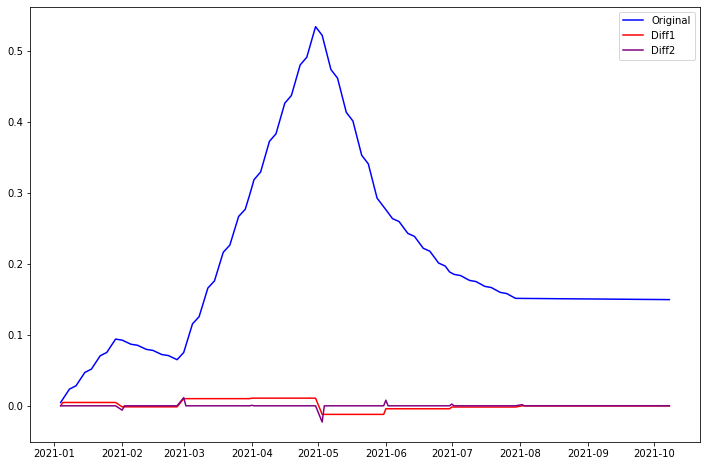

Result of ADF--c Test 
timeseries_adf :  (-2.5103494035644136, 0.11297646741536993, 1, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, -1761.9699925922282)
timeseries_diff1_adf :  (-2.1273355171257373, 0.2336658389136101, 0, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, -1758.0102597085752)
timeseries_diff2_adf :  (-14.0377608007789, 3.3455806140807555e-26, 0, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, -1753.6326793155686)


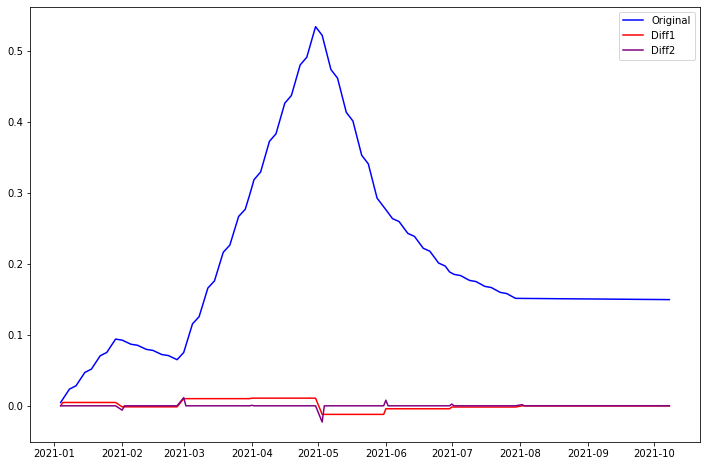

Result of ADF--nc Test 
timeseries_adf :  (-1.243258337389298, 0.19647593406335212, 1, 198, {'1%': -2.577124435261708, '5%': -1.9424383763922255, '10%': -1.6155445459389322}, -1759.4918992662178)
timeseries_diff1_adf :  (-2.1198537409998806, 0.03262619099309668, 0, 199, {'1%': -2.5770667644756444, '5%': -1.942430759336949, '10%': -1.615550641718986}, -1760.0086451431034)
timeseries_diff2_adf :  (-14.071271589666294, 2.119045824589671e-25, 0, 199, {'1%': -2.5770667644756444, '5%': -1.942430759336949, '10%': -1.615550641718986}, -1755.6033625371847)


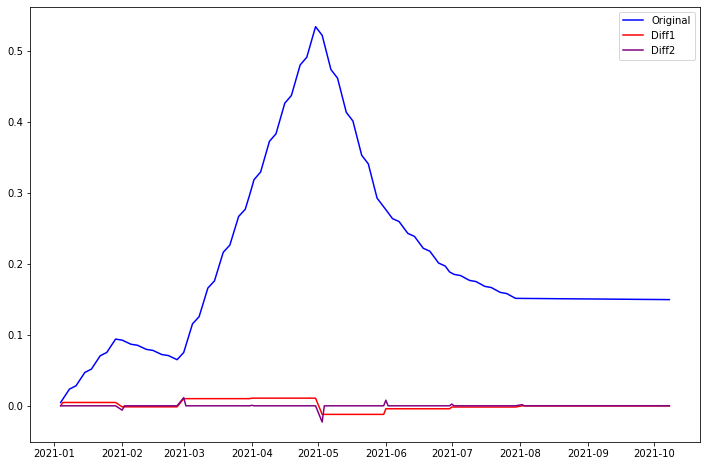

Resulty of ADF -- CrudeOilExports_UStoCanada
Result of ADF--ct Test 
timeseries_adf :  (-5.27342849123962, 6.353333194088372e-05, 1, 198, {'1%': -4.005235140049614, '5%': -3.4329000694219, '10%': -3.1402115863254525}, 929.4781238594446)
timeseries_diff1_adf :  (-3.014397590075549, 0.12810014260326175, 0, 199, {'1%': -4.004997848936356, '5%': -3.4327862452981046, '10%': -3.140144918368515}, 940.6135214514181)
timeseries_diff2_adf :  (-14.175395357144989, 7.732447423429318e-22, 0, 199, {'1%': -4.004997848936356, '5%': -3.4327862452981046, '10%': -3.140144918368515}, 971.1973775257889)


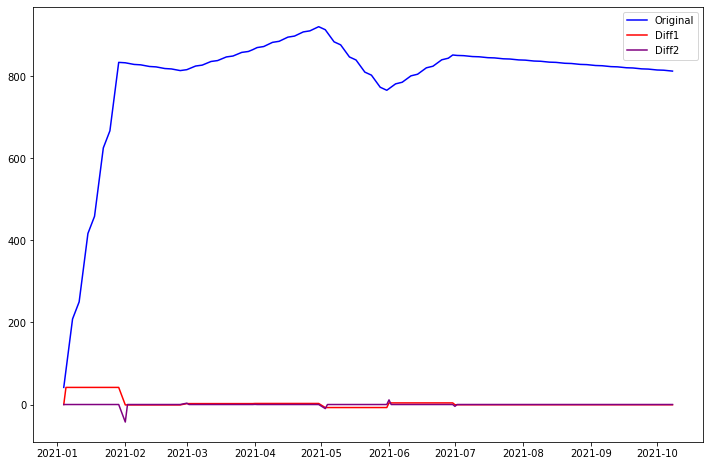

Result of ADF--c Test 
timeseries_adf :  (-5.269184497042087, 6.340556211521973e-06, 1, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, 928.207225789736)
timeseries_diff1_adf :  (-2.465194651138366, 0.12417410062677264, 0, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 938.6280696627603)
timeseries_diff2_adf :  (-14.096592036076004, 2.663697368074734e-26, 0, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 971.503430926367)


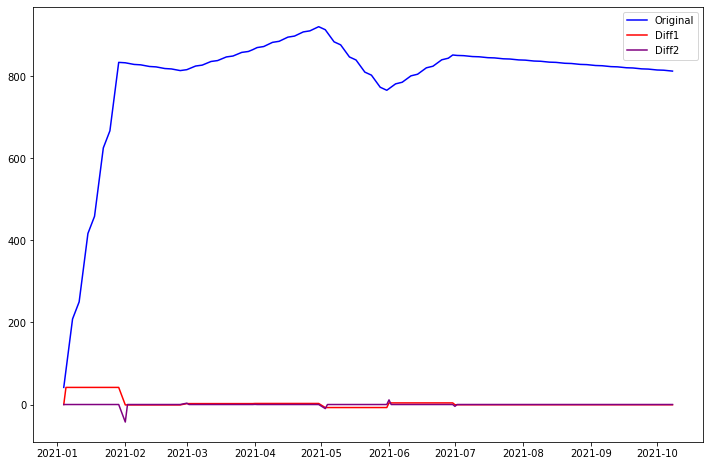

Result of ADF--nc Test 
timeseries_adf :  (-0.5013710576228201, 0.49556039978339206, 1, 198, {'1%': -2.577124435261708, '5%': -1.9424383763922255, '10%': -1.6155445459389322}, 938.5566665711088)
timeseries_diff1_adf :  (-2.3624436388918473, 0.017495263410385768, 0, 199, {'1%': -2.5770667644756444, '5%': -1.942430759336949, '10%': -1.615550641718986}, 936.665835223635)
timeseries_diff2_adf :  (-14.071247279470288, 2.1192197569481893e-25, 0, 199, {'1%': -2.5770667644756444, '5%': -1.942430759336949, '10%': -1.615550641718986}, 970.3676660640656)


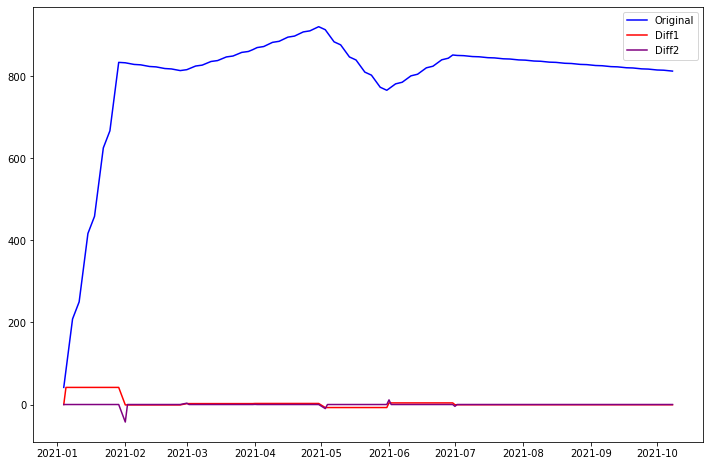

Resulty of ADF -- USD_CAD
Result of ADF--ct Test 
timeseries_adf :  (-1.4037280759658817, 0.8598147933137937, 4, 195, {'1%': -4.005961859943694, '5%': -3.433248624251926, '10%': -3.1404157270014665}, -1390.0662036113963)
timeseries_diff1_adf :  (-8.846072895450371, 8.107313245471522e-13, 3, 196, {'1%': -4.005717107046171, '5%': -3.4331312406289043, '10%': -3.1403469799998303}, -1389.6564201392293)
timeseries_diff2_adf :  (-9.7944063932384, 6.3459648780925006e-15, 7, 192, {'1%': -4.006711675454599, '5%': -3.433608194523564, '10%': -3.1406263010660807}, -1373.0841375283148)


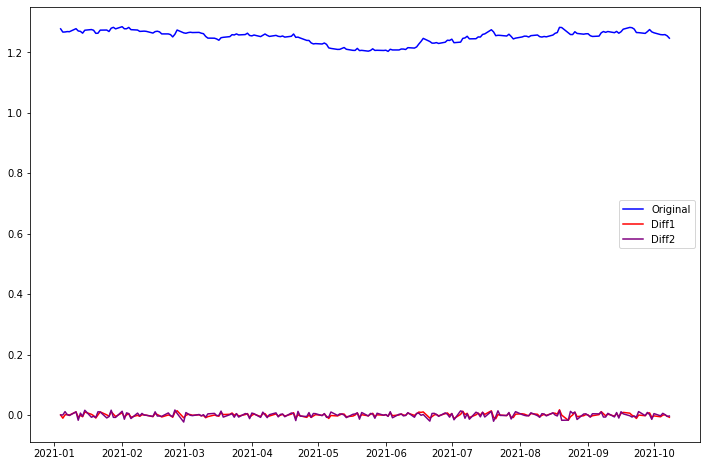

Result of ADF--c Test 
timeseries_adf :  (-1.4619323840287843, 0.5522518297768996, 4, 195, {'1%': -3.464337030867007, '5%': -2.876478799035722, '10%': -2.574733103221565}, -1391.5923033795284)
timeseries_diff1_adf :  (-8.849455665233988, 1.5874692694615236e-14, 3, 196, {'1%': -3.464161278384219, '5%': -2.876401960790147, '10%': -2.5746921001665974}, -1391.1322369451761)
timeseries_diff2_adf :  (-9.795835314923025, 6.178123774677789e-17, 7, 192, {'1%': -3.4648754262570978, '5%': -2.876714157488788, '10%': -2.574858699001736}, -1374.9633835157174)


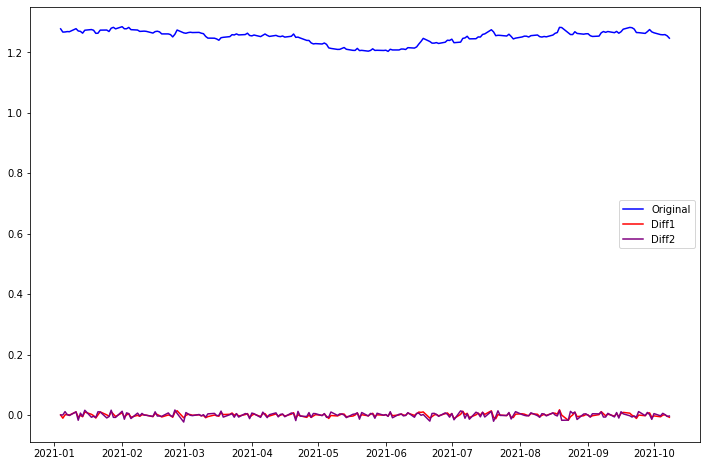

Result of ADF--nc Test 
timeseries_adf :  (-0.3662696028213134, 0.5501399777366716, 4, 195, {'1%': -2.5773010256410256, '5%': -1.9424617194490805, '10%': -1.6155259021224229}, -1391.1539628659577)
timeseries_diff1_adf :  (-8.863220942940929, 3.521214498088155e-15, 3, 196, {'1%': -2.5772415566430653, '5%': -1.9424538551379529, '10%': -1.6155321770053293}, -1392.9657895654746)
timeseries_diff2_adf :  (-9.823229244240562, 2.4501274696047852e-17, 7, 192, {'1%': -2.5774831803385414, '5%': -1.9424858284561723, '10%': -1.6155067050736038}, -1376.8741883017442)


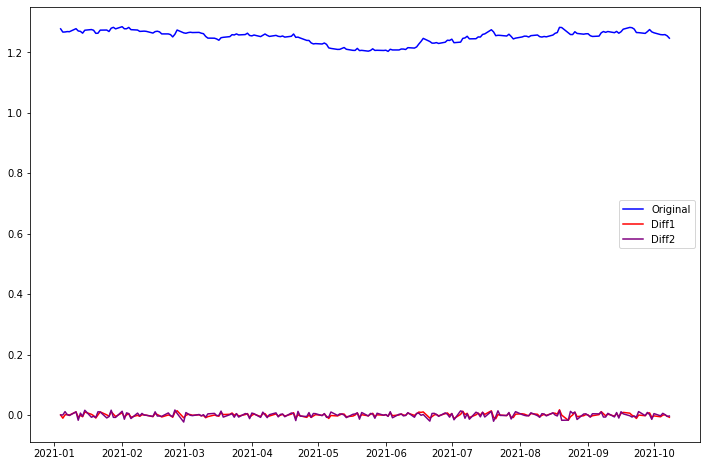

In [339]:
def ADF_diff(timeseries, name):
    
    """
    ADF: Augmented Dickey-Fuller unit root test.
    
    Regression: Constant and trend order to include {“c”,”ct”,”ctt”,”nc”}
    1. “c” : constant only (default).
    2. “ct” : constant and trend.
    3. “ctt” : constant, and linear and quadratic trend.
    4. “nc” : no constant, no trend.
    """

    import pandas as pd
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from statsmodels.tsa.stattools import adfuller as ADF
    
    # Sequence after generating the differencing.
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    # ADF unit root test -- ct
    print('Result of ADF--ct Test ')
    timeseries_adf = ADF(timeseries[name].tolist(), regression='ct')
    timeseries_diff1_adf = ADF(timeseries_diff1[name].tolist(), regression='ct')
    timeseries_diff2_adf = ADF(timeseries_diff2[name].tolist(), regression='ct')

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12, 8))
    plt.plot(timeseries, label='Original', color='blue')
    plt.plot(timeseries_diff1, label='Diff1', color='red')
    plt.plot(timeseries_diff2, label='Diff2', color='purple')
    plt.legend(loc='best')
    plt.show()
    
    # ADF unit root test -- c
    print('Result of ADF--c Test ')
    timeseries_adf = ADF(timeseries[name].tolist(), regression='c')
    timeseries_diff1_adf = ADF(timeseries_diff1[name].tolist(), regression='c')
    timeseries_diff2_adf = ADF(timeseries_diff2[name].tolist(), regression='c')

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12, 8))
    plt.plot(timeseries, label='Original', color='blue')
    plt.plot(timeseries_diff1, label='Diff1', color='red')
    plt.plot(timeseries_diff2, label='Diff2', color='purple')
    plt.legend(loc='best')
    plt.show()
    
    # ADF unit root test -- nc
    print('Result of ADF--nc Test ')
    timeseries_adf = ADF(timeseries[name].tolist(), regression='nc')
    timeseries_diff1_adf = ADF(timeseries_diff1[name].tolist(), regression='nc')
    timeseries_diff2_adf = ADF(timeseries_diff2[name].tolist(), regression='nc')

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12, 8))
    plt.plot(timeseries, label='Original', color='blue')
    plt.plot(timeseries_diff1, label='Diff1', color='red')
    plt.plot(timeseries_diff2, label='Diff2', color='purple')
    plt.legend(loc='best')
    plt.show()

# Parse data with date for training   
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
train_data = pd.read_csv('./train_data.csv', parse_dates=['Date'],
                                 index_col='Date', date_parser=dateparse)

# Extract the data of each variable for future use
data_WTI = pd.DataFrame(train_data['WTI'])
data_XAU_USD = pd.DataFrame(train_data['XAU_USD'])
data_Sales_Rate = pd.DataFrame(train_data['Sales_Rate'])
data_CrudeOilExports_UStoCanada = pd.DataFrame(train_data['CrudeOilExports_UStoCanada'])
data_USD_CAD = pd.DataFrame(train_data['USD_CAD'])

# ADF Tests
print("Resulty of ADF -- WTI")
ADF_diff(data_WTI, 'WTI')
print("Resulty of ADF -- XAU_USD")
ADF_diff(data_XAU_USD, 'XAU_USD')
print("Resulty of ADF -- Sales_Rate")
ADF_diff(data_Sales_Rate, 'Sales_Rate')
print("Resulty of ADF -- CrudeOilExports_UStoCanada")
ADF_diff(data_CrudeOilExports_UStoCanada, 'CrudeOilExports_UStoCanada')
print("Resulty of ADF -- USD_CAD")
ADF_diff(data_USD_CAD, 'USD_CAD')

### Fit Comparison Estimates of AIC, BIC, FPE, and HQIC.

##### Using fit comparison estimates of AIC, BIC, FPE, and HQIC. 
##### Using the Fit comparison estimates to derive the most optimal number of lags for the model.

In [340]:
def order_selection(timeseries):
    
    """
    Select the optimal lag order.
    
    Use Vector Auto Regression (VAR) Model to select order.
    The var model can pass a maximum number of lags and the order criterion to use for lag order selection.
    """
    
    import statsmodels.api as sm
    from statsmodels.tsa.api import VAR
    
    # Vector Auto Regression (VAR) Model
    var_model = VAR(timeseries)

    #Lag order selection
    order = var_model.select_order(10)
    print(order.summary())
    
    #var_results = var_model.fit(maxlags=5, ic='aic')
    #var_results.summary()


# Use original data to select order
order_selection(train_data)

# data after differencing
train_data_diff = train_data

data_WTI_diff1 = data_WTI.diff(1)
data_WTI_diff1 = data_WTI_diff1.fillna(0)
train_data_diff['WTI'] = data_WTI_diff1

data_XAU_USD_diff1 = data_XAU_USD.diff(1)
data_XAU_USD_diff1 = data_XAU_USD_diff1.fillna(0)
train_data_diff['XAU_USD'] = data_XAU_USD_diff1

data_Sales_Rate_diff1 = data_Sales_Rate.diff(1)
data_Sales_Rate_diff2 = data_Sales_Rate_diff1.diff(1)
data_Sales_Rate_diff2 = data_Sales_Rate_diff2.fillna(0)
train_data_diff['Sales_Rate'] = data_Sales_Rate_diff2

data_CrudeOilExports_UStoCanada_diff1 = data_CrudeOilExports_UStoCanada.diff(1)
data_CrudeOilExports_UStoCanada_diff2 = data_CrudeOilExports_UStoCanada_diff1.diff(1)
data_CrudeOilExports_UStoCanada_diff2 = data_CrudeOilExports_UStoCanada_diff2.fillna(0)
train_data_diff['CrudeOilExports_UStoCanada'] = data_CrudeOilExports_UStoCanada_diff2

data_USD_CAD_diff1 = data_USD_CAD.diff(1)
data_USD_CAD_diff1 = data_USD_CAD_diff1.fillna(0)
train_data_diff['USD_CAD'] = data_USD_CAD_diff1

# Use data after differencing to select order
order_selection(train_data_diff)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.908       5.994       368.1       5.943
1       -12.47      -11.96   3.831e-06      -12.26
2      -15.36*     -14.42*  2.126e-07*     -14.98*
3       -15.27      -13.91   2.332e-07      -14.72
4       -15.11      -13.32   2.751e-07      -14.38
5       -15.05      -12.83   2.934e-07      -14.15
6       -14.94      -12.29   3.284e-07      -13.87
7       -14.78      -11.71   3.882e-07      -13.54
8       -14.60      -11.10   4.701e-07      -13.19
9       -14.53      -10.60   5.158e-07      -12.93
10      -14.40      -10.05   5.941e-07      -12.64
--------------------------------------------------
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -15.14*     -15.06*  2.648e-07*     -15.11*
1       -15.06      -14.55   2.

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


### Johassen’s test of cointegration

Johansen cointegration test using trace test statistic with 10% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   5          452.1          65.82
  1   5          332.1          44.49
  2   5          225.8          27.07
  3   5          141.1          13.43
  4   5          68.06          2.705
-------------------------------------
5
[['Order']
 ['trace statistics']
 ['CV 90%']
 ['CV 95%']
 ['CV 99%']]
[0 1 2 3 4]
[452.14644816 332.14927878 225.76518768 141.08075629  68.05848772]
[[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


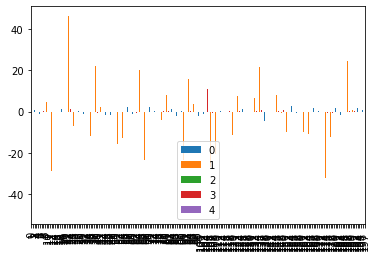

In [345]:
def coint_johansen(timeseries):
    
    """
    Johassen’s test of cointegration
    
    Use the Johassen’s test of cointegration to check statistical significance in your variables. 
    """
    
    from statsmodels.tsa.vector_ar import vecm
    
    # Johansen cointegration test, situation setting = continuous features
    jres1 = vecm.coint_johansen(timeseries, det_order=0, k_ar_diff=1)

    # View johansen cointegration test results
    johansen_result = vecm.select_coint_rank(timeseries,det_order=0, k_ar_diff=1, signif=0.1)
    print(johansen_result.summary())

    # Choice of rank
    print(johansen_result.rank)

    j_name=np.array([['Order'], ['trace statistics'], ['CV 90%'],  ['CV 95%'], ['CV 99%'] ] )
    print(j_name)
    
    j_order = jres1.ind 
    print(j_order) # Order of eigenvalues 
    
    j_lr1 = jres1.lr1 
    print(j_lr1) # trace statistics
    
    j_cvt = jres1.cvt 
    print(j_cvt) # Critical values (90%, 95%, 99%) of trace statistic

    # j_result = np.vstack(( j_order,  j_lr1, j_cvt))
    # print(j_result)

    pd.DataFrame(jres1.r0t).plot(kind='bar')  # Residuals for Δ
    
    
coint_johansen(train_data_diff)

### e.	[Forecast] Utilizing your model, forecast the daily close for the next five days, include a 75% confidence interval. Derive the USD/CAD closing price range for the next 5 days (i.e., Min & Max).


### VECM Model

In [346]:
# Use VECM Model to Forecast
mod = vecm.VECM(train_data_diff, k_ar_diff=1, coint_rank=5, freq='B', deterministic="ci")
res = mod.fit()
print(res.summary())

        Det. terms outside the coint. relation & lagged endog. parameters for equation WTI       
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
L1.WTI                            0.1079      0.079      1.369      0.171      -0.047       0.262
L1.XAU_USD                        0.0120      0.007      1.790      0.074      -0.001       0.025
L1.Sales_Rate                    -2.0531     53.224     -0.039      0.969    -106.370     102.264
L1.CrudeOilExports_UStoCanada     0.0239      0.033      0.733      0.464      -0.040       0.088
L1.USD_CAD                       16.1911     20.768      0.780      0.436     -24.514      56.896
      Det. terms outside the coint. relation & lagged endog. parameters for equation XAU_USD     
                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------

(array([[ 4.96560856e-01, -3.60033578e+00, -3.80249197e-04,
         -5.51977849e-01,  7.15709180e-04],
        [ 6.40179073e-02, -4.34262697e+00, -2.13272337e-04,
         -8.19465244e-02,  1.22341252e-03],
        [ 8.48561941e-02, -3.92768187e-01,  3.92516153e-05,
         -1.63001589e-01, -1.38756223e-04],
        [ 1.82272530e-01, -2.74726582e-02, -6.64761213e-06,
         -2.59352402e-01, -4.41301519e-04],
        [ 1.62581727e-01, -1.03941738e+00, -3.40946240e-05,
         -2.25377465e-01, -1.21886071e-04]]),
 array([[ 9.30303641e-02, -8.28310512e+00, -1.00018437e-03,
         -1.57711203e+00, -9.95102654e-04],
        [-3.51061654e-01, -9.16335276e+00, -8.37564293e-04,
         -1.11168347e+00, -5.17041317e-04],
        [-3.33921217e-01, -5.30916325e+00, -5.86896291e-04,
         -1.19316312e+00, -1.91078202e-03],
        [-2.37163099e-01, -4.94711834e+00, -6.33030527e-04,
         -1.28973005e+00, -2.21482775e-03],
        [-2.56917650e-01, -5.96363146e+00, -6.60539666e-04,
  

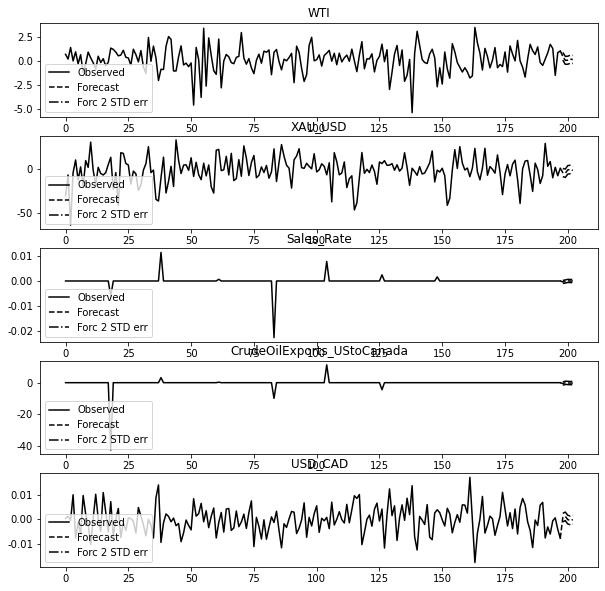

In [347]:
"""
Notes:

forecast - ndarray (steps x neqs) or three ndarrays

In case of a point forecast: each row of the returned ndarray represents the forecast of the neqs variables for a specific period. 
The first row (index [0]) is the forecast for the next period, the last row (index [steps-1]) is the steps-periods-ahead- forecast.
"""

# An image of data that predicts one step forward (showing confidence interval, confidence interval 75%)
res.plot_forecast(steps=5,plot_conf_int=True,alpha=0.75)

# Predict the value one step forward, with 75% confidence
res.predict(steps=5, alpha=0.75)
